In [21]:
%reload_ext autoreload
%autoreload 2

In [49]:
import autorootcwd
import numpy as np
import librosa
import os
from librosa.display import specshow
import matplotlib.pyplot as plt

from src.utils import get_cqt, get_filenames, get_chord_annotation, SR, HOP_LENGTH, BINS_PER_OCTAVE, get_annotation_metadata

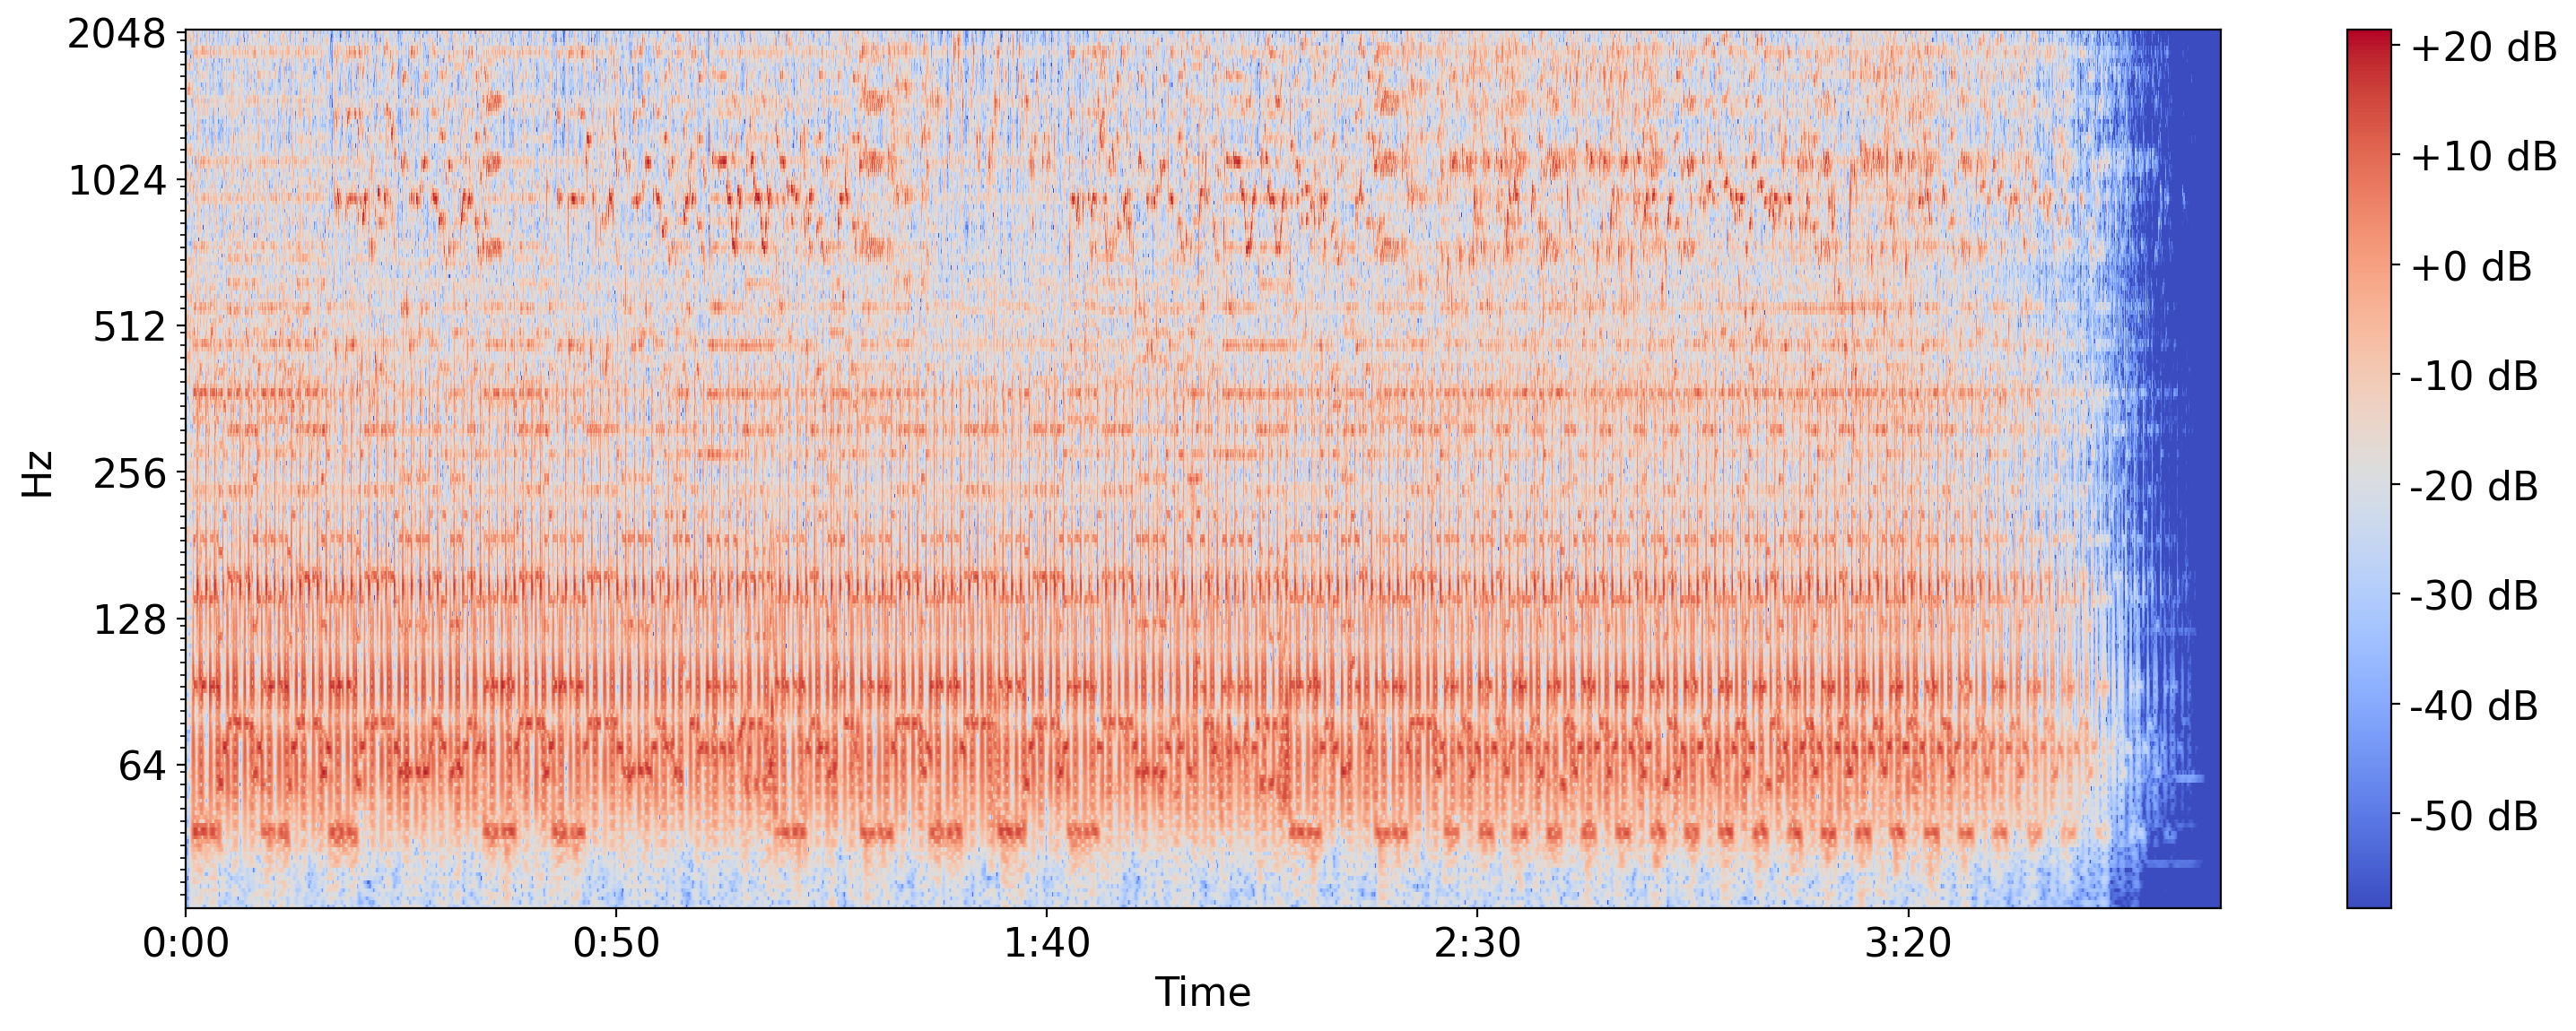

In [83]:
idx = 200
filenames = get_filenames()
cqt = get_cqt(filenames[idx], return_as_tensor=False).T

metadata = get_annotation_metadata(filenames[idx])
title = f"{metadata['title']} - {metadata['artist']}"
plt.figure(figsize=(30,6))
plt.subplot(1, 2, 2)
# Set font size and of axis labels
plt.rcParams.update({'font.size': 16, 'axes.labelsize': 16})
img = librosa.display.specshow(cqt, y_axis='cqt_hz', x_axis='time', sr=SR, hop_length=HOP_LENGTH, bins_per_octave=BINS_PER_OCTAVE)
plt.colorbar(img, format="%+2.f dB")
# plt.title(title)
plt.tight_layout()
# Save the figure to report/figures/sample_cqt.png in high quality
plt.savefig("report/figures/sample_cqt.png", bbox_inches='tight', dpi=100)
plt.show()
plt.close()


In [38]:
from scipy.signal import correlate
import jams
import librosa

import numpy as np

def get_chord_annotation(file_name):
    jam = jams.load(os.path.join('./data/processed/chords/', f'{file_name}.jams'))
    chord_ann = jam.annotations.search(namespace="chord")[0]
    return chord_ann.data

def convert_chords_to_binary(cqt, chords, sr, hop_length, duration):
    # Create a binary vector for chord changes where 1 indicates a chord change and 0 indicates no change
    # Assuming a time resolution similar to the spectrogram hop length
    binary_chords = np.zeros(cqt.shape[1])
    for chord in chords:
        start = librosa.time_to_frames(chord.time, sr=sr, hop_length=hop_length)
        # if start < len(binary_chords):
        binary_chords[start] = 1
    return binary_chords

def get_max_corr(filename):
    cqt = get_cqt(filename, return_as_tensor=False).T
    chord_ann = get_chord_annotation(filename)
    binary_chords = convert_chords_to_binary(cqt, chord_ann, SR, HOP_LENGTH, cqt.shape[1])
    
    delta = librosa.feature.delta(cqt) # (24*7, Frames)
    delta_magnitude = np.sqrt(np.sum(delta**2, axis=0)) # (Frames)

    # Standardize the features
    delta_magnitude = (delta_magnitude - np.mean(delta_magnitude)) / np.std(delta_magnitude)
    binary_chords = (binary_chords - np.mean(binary_chords)) / np.std(binary_chords)
    
    # Get cross-correlation of chord changes and log-cqt delta  
    corr = correlate(delta_magnitude, binary_chords, mode='full')
    
    lags = np.arange(-len(binary_chords)+1, len(binary_chords))
    max_lag = lags[np.argmax(corr)]
    
    return max_lag, corr, lags, len(binary_chords)


Maximum correlation lag: 1 frames
(6027,) (6027,)


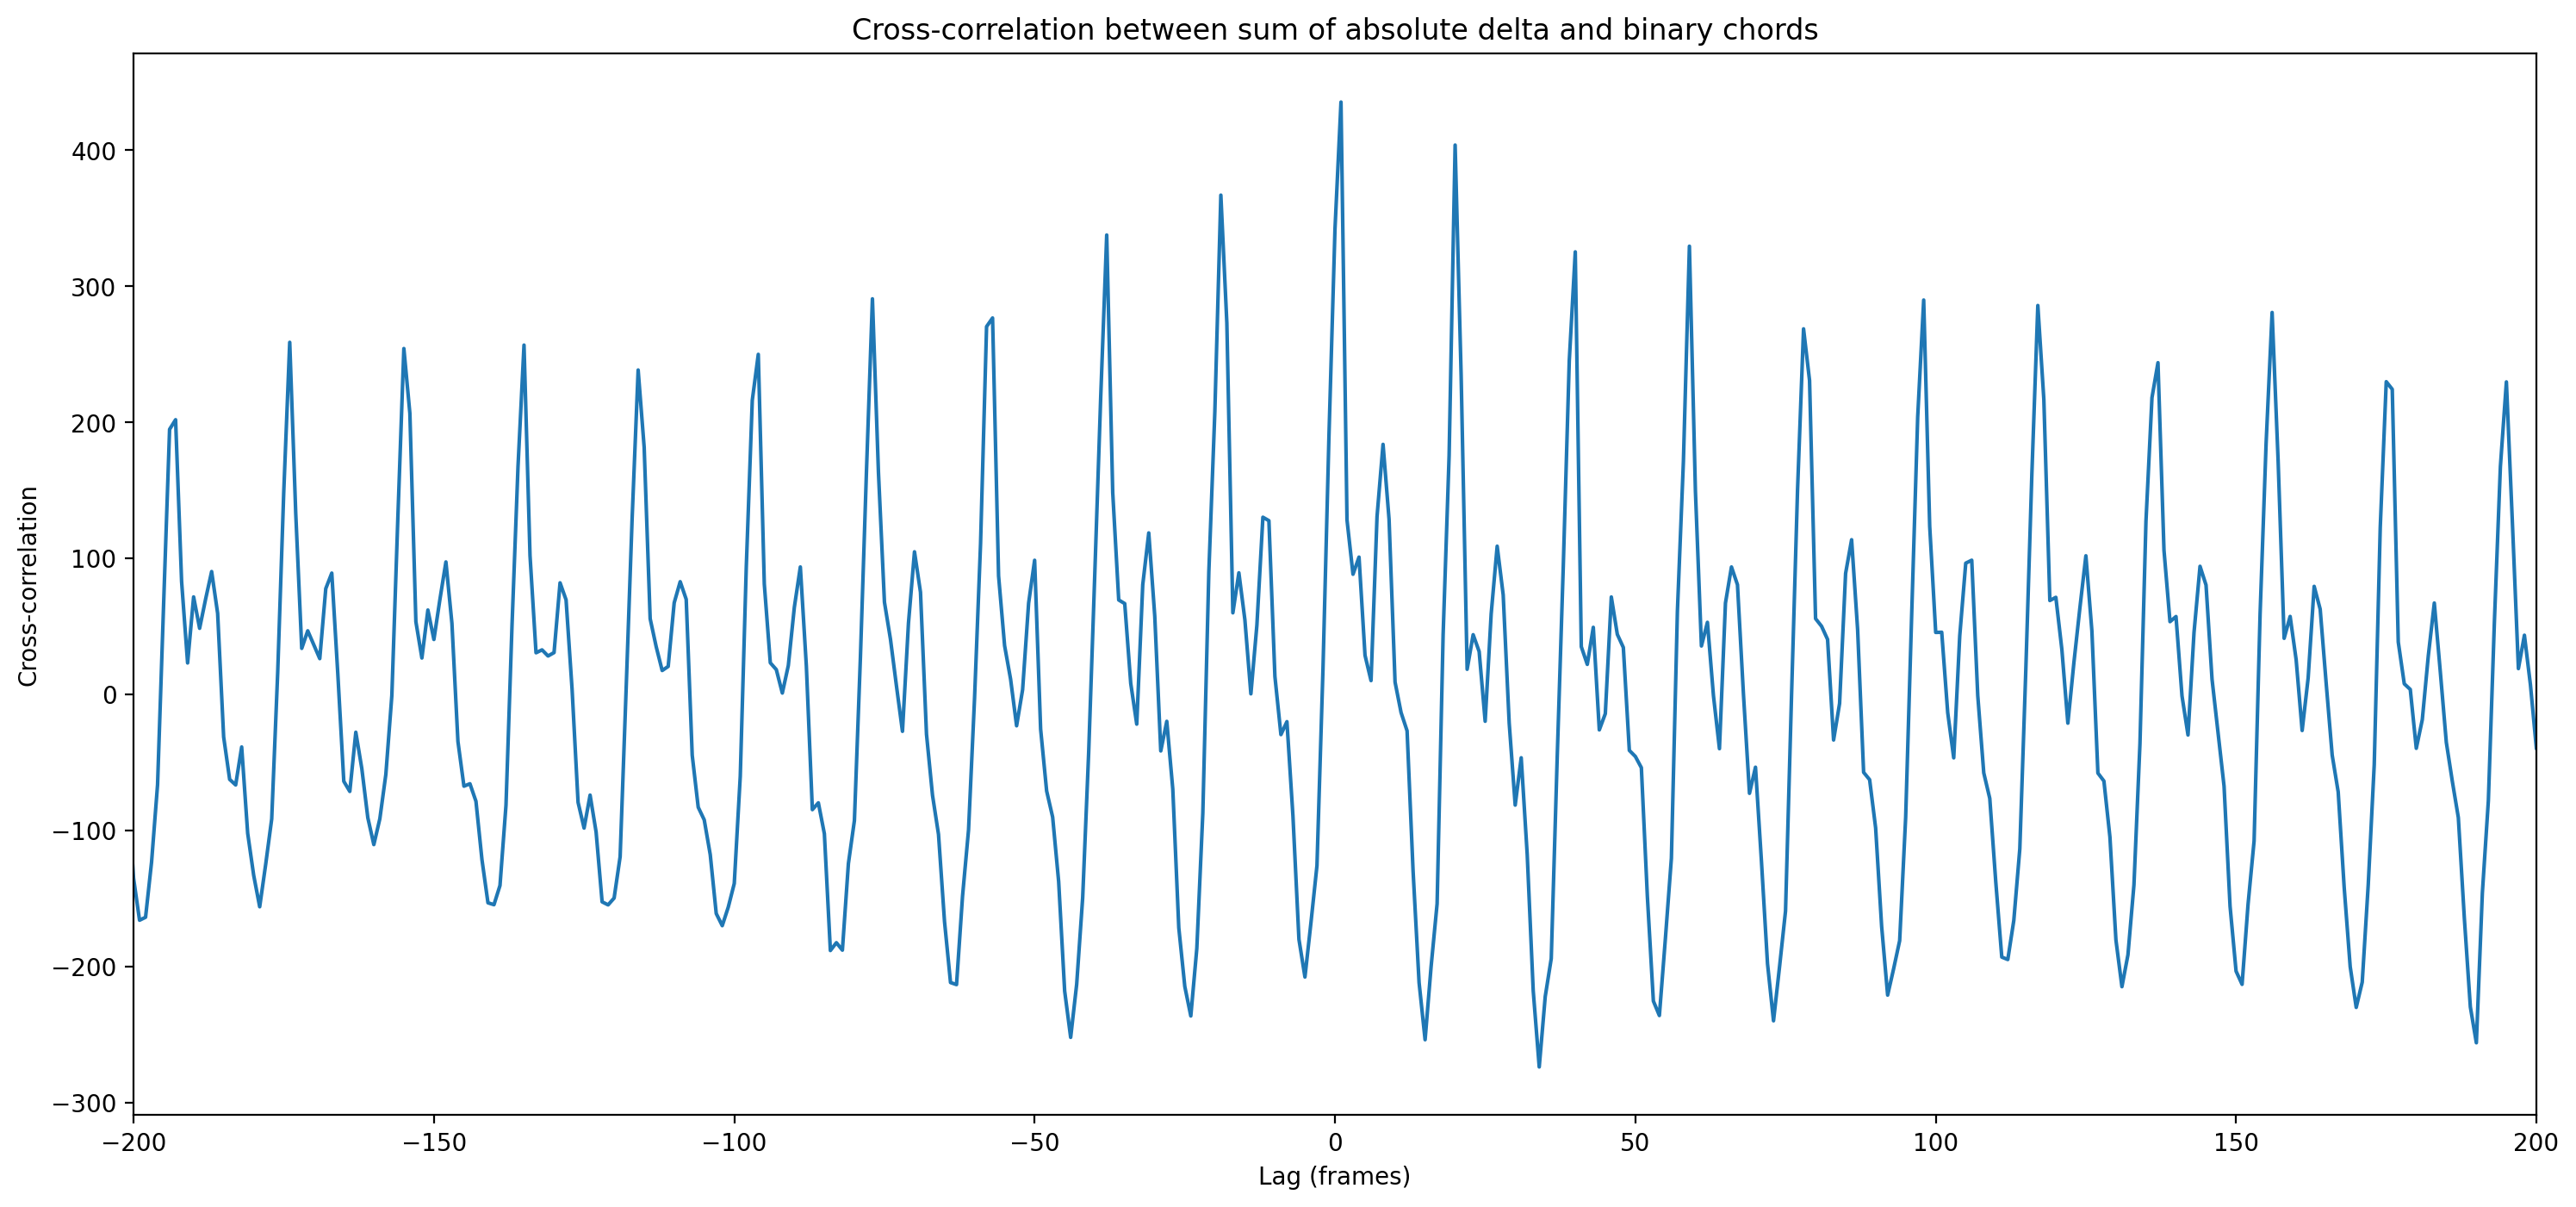

In [39]:
filename = filenames[20]

max, corr, lags, _ = get_max_corr(filename)
print(f'Maximum correlation lag: {max} frames')
plt.figure(figsize=(18, 8))
print(lags.shape, corr.shape)
plt.plot(lags, corr)
plt.xlabel('Lag (frames)')
plt.ylabel('Cross-correlation')
plt.title('Cross-correlation between sum of absolute delta and binary chords')
plt.xlim(-200, 200)
plt.show()

In [40]:
from tqdm import tqdm
import pandas as pd

rows = []
for file_name in tqdm(filenames):
    max, corr, lags, frames = get_max_corr(file_name)
    row = {
        'file_name': file_name,
        'max_lag': max
    }

    for window in [200, 100, 50, 25]:
        max_within = np.argmax(corr[frames-window:frames+window]) - window
        row.update({f'max_lag_{window}': max_within})
    
    rows.append(row)

df = pd.DataFrame(rows)

100%|██████████| 1213/1213 [14:05<00:00,  1.43it/s]


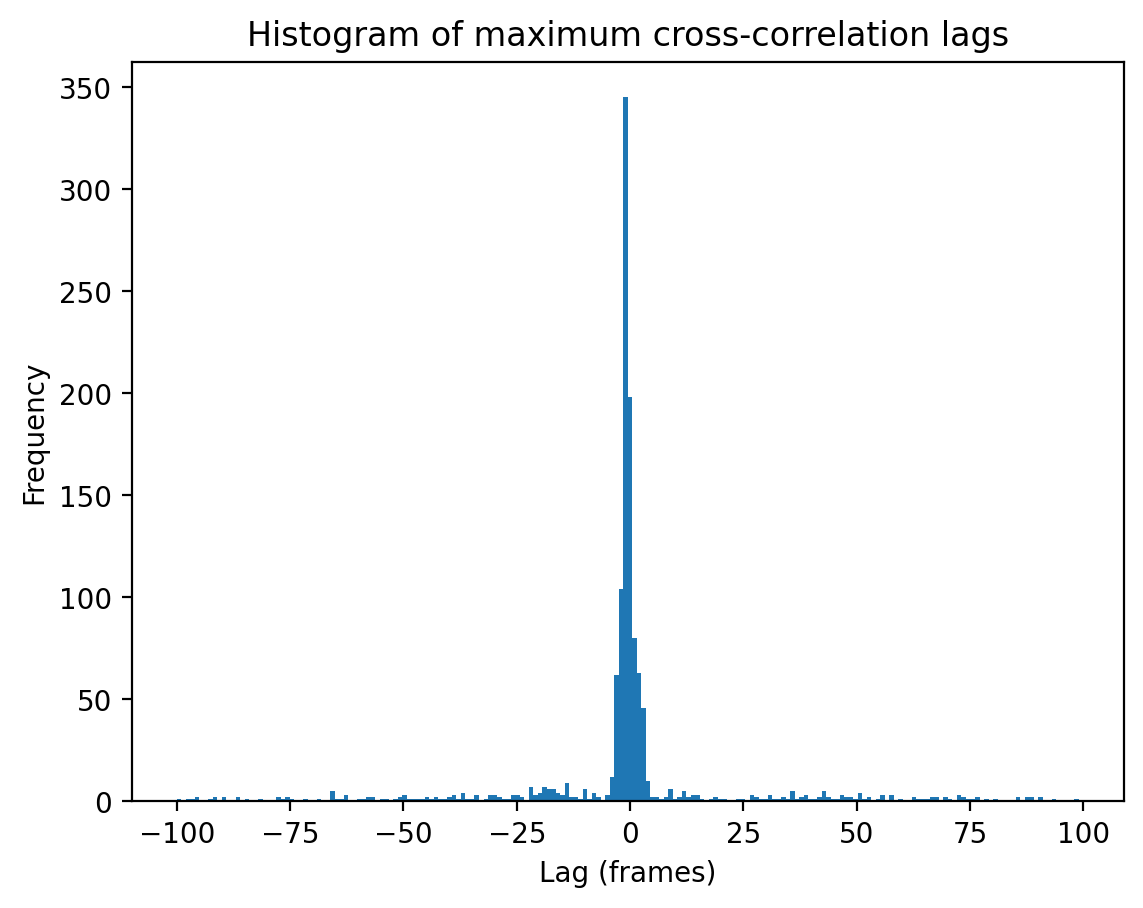

In [47]:
plt.hist(df['max_lag_100'], bins=200)
plt.xlabel('Lag (frames)')
plt.ylabel('Frequency')
plt.title('Histogram of maximum cross-correlation lags')
plt.show()

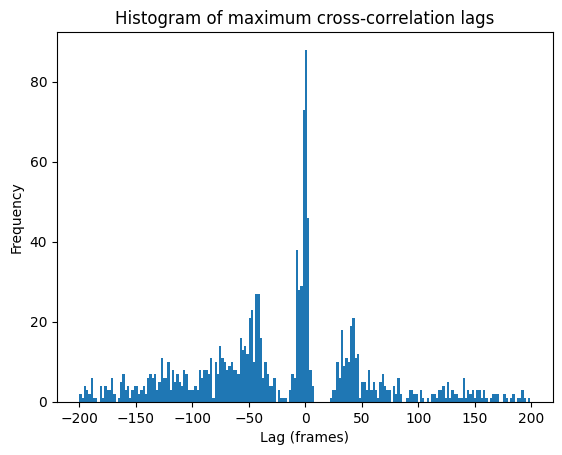

In [193]:
plt.hist(df['max_lag_200'], bins=200)
plt.xlabel('Lag (frames)')
plt.ylabel('Frequency')
plt.title('Histogram of maximum cross-correlation lags')
plt.show()

In [189]:
df

,file_name,max_lag,max_lag_200,max_lag_100,max_lag_50,max_lag_25
0,TR6R91L11C8A40D710,-66,-67,-67,49,-23
1,TRACGVT149E3B9BE3F,-2,-3,-3,-3,-3
2,TRACPPB149E33C10B9,-3,-4,-4,-4,-4
3,TRADINA127F847B84E,-87,-88,-88,-7,-7
4,TRAEQJQ149E3BA694B,-40,-41,-41,-41,-1
...,...,...,...,...,...,...
1212,TRZUUDG149E37F179C,-93,-94,-94,-10,-10
1213,TRZUXXY149E39C2D8E,3,2,2,2,2
1214,TRZWERX149E381FF71,-121,-122,-35,-35,1
1215,TRZWISM149E35CA148,-107,-108,-37,-37,-1
